In [1]:
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



torch.Size([128, 3, 32, 32]) torch.Size([128])
 deer plane   car horse


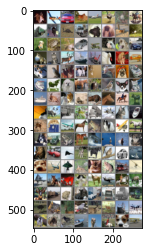

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = next(iter(trainloader))
images, labels = dataiter
print(images.shape,labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
# import torch.nn as nn
# import torch.nn.functional as F

# # C1-C2-C3-C4-Output
# # No Max Pooling
# # Kernel (3X3), stride (2,2)
# # RF must be 44
# # one of depthwise
# # one of dilated convs
# # use GAP - can add FC after gap 
# # Albumentations: Flip, shiftscaleRotate,Cutout
# # 85% accuracy
# # 200K parameters

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# C1-C2-C3-C4-Output
# No Max Pooling
# Kernel (3X3), stride (2,2)
# RF must be 44
# one of depthwise
# one of dilated convs
# use GAP - can add FC after gap 
# Albumentations: Flip, shiftscaleRotate,Cutout
# 85% accuracy
# 200K parameters

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # (32+2-3) + 1 = 32
           
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # (32-3) + 1 = 30
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU())
            # (30-3)+ 1 = 28
            
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=128,kernel_size=(3,3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (28-3)/1+ 1 = 26
           
          
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3),dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # (26-5) + 1 = 22
           
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3),padding=1,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
            # (22+2-3)/2+1 = 11
            
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, groups=8),
            nn.BatchNorm2d(128),
            # 9
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 9
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU())
            # (9-3)/1 + 1 = 7
            
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),
            # (7-3) + 1 = 5
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(3,3)),
            nn.BatchNorm2d(16),
            # (5-3) + 1 = 3 
            nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(3,3)))

        self.gap = nn.AvgPool2d(1)
        
        self.dropout = nn.Dropout2d(0.2)
        
        
        
    def forward(self, x):
            x = self.conv1(x)
            x = self.dropout(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.dropout(x)
            x = self.conv4(x)
            x = self.gap(x)
            x = x.view(-1,10)
            return F.log_softmax(x,dim=1)

net = Net()



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))
print(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 30, 30]           4,640
       BatchNorm2d-5           [-1, 32, 30, 30]              64
              ReLU-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
        Dropout2d-10           [-1, 32, 28, 28]               0
           Conv2d-11          [-1, 128, 26, 26]          36,992
      BatchNorm2d-12          [-1, 128, 26, 26]             256
             ReLU-13          [-1, 128, 26, 26]               0
           Conv2d-14           [-1, 64,

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [17]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 32
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.4667086601257324 Batch_id=390 train-Accuracy=36.46: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]



Test set: Average loss: 0.0113, val-Accuracy: 4664/10000 (46.64%)

EPOCH: 1


Loss=1.1701714992523193 Batch_id=390 train-Accuracy=50.47: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s]



Test set: Average loss: 0.0095, val-Accuracy: 5546/10000 (55.46%)

EPOCH: 2


Loss=0.8808422088623047 Batch_id=390 train-Accuracy=56.81: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]



Test set: Average loss: 0.0087, val-Accuracy: 6045/10000 (60.45%)

EPOCH: 3


Loss=1.3054426908493042 Batch_id=390 train-Accuracy=61.42: 100%|██████████| 391/391 [00:16<00:00, 23.41it/s]



Test set: Average loss: 0.0079, val-Accuracy: 6450/10000 (64.50%)

EPOCH: 4


Loss=0.7599388360977173 Batch_id=390 train-Accuracy=64.76: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]



Test set: Average loss: 0.0072, val-Accuracy: 6754/10000 (67.54%)

EPOCH: 5


Loss=0.818832278251648 Batch_id=390 train-Accuracy=67.53: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s] 



Test set: Average loss: 0.0071, val-Accuracy: 6799/10000 (67.99%)

EPOCH: 6


Loss=0.9792205691337585 Batch_id=390 train-Accuracy=69.38: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s]



Test set: Average loss: 0.0067, val-Accuracy: 7022/10000 (70.22%)

EPOCH: 7


Loss=0.8524037599563599 Batch_id=390 train-Accuracy=71.00: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 0.0062, val-Accuracy: 7222/10000 (72.22%)

EPOCH: 8


Loss=0.6922896504402161 Batch_id=390 train-Accuracy=72.61: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]



Test set: Average loss: 0.0067, val-Accuracy: 6971/10000 (69.71%)

EPOCH: 9


Loss=0.7851064205169678 Batch_id=390 train-Accuracy=73.68: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s]



Test set: Average loss: 0.0062, val-Accuracy: 7301/10000 (73.01%)

EPOCH: 10


Loss=0.9819154739379883 Batch_id=390 train-Accuracy=74.88: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]



Test set: Average loss: 0.0061, val-Accuracy: 7313/10000 (73.13%)

EPOCH: 11


Loss=0.8137709498405457 Batch_id=390 train-Accuracy=75.75: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]



Test set: Average loss: 0.0056, val-Accuracy: 7543/10000 (75.43%)

EPOCH: 12


Loss=0.8770502209663391 Batch_id=390 train-Accuracy=76.91: 100%|██████████| 391/391 [00:17<00:00, 22.64it/s] 



Test set: Average loss: 0.0056, val-Accuracy: 7515/10000 (75.15%)

EPOCH: 13


Loss=0.6066347360610962 Batch_id=390 train-Accuracy=77.89: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s] 



Test set: Average loss: 0.0056, val-Accuracy: 7520/10000 (75.20%)

EPOCH: 14


Loss=0.6650611758232117 Batch_id=390 train-Accuracy=78.33: 100%|██████████| 391/391 [00:16<00:00, 23.48it/s] 



Test set: Average loss: 0.0060, val-Accuracy: 7397/10000 (73.97%)

EPOCH: 15


Loss=0.6424655318260193 Batch_id=390 train-Accuracy=78.94: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s] 



Test set: Average loss: 0.0055, val-Accuracy: 7637/10000 (76.37%)

EPOCH: 16


Loss=0.5743089914321899 Batch_id=390 train-Accuracy=79.80: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s] 



Test set: Average loss: 0.0054, val-Accuracy: 7642/10000 (76.42%)

EPOCH: 17


Loss=0.45726901292800903 Batch_id=390 train-Accuracy=80.07: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]



Test set: Average loss: 0.0054, val-Accuracy: 7637/10000 (76.37%)

EPOCH: 18


Loss=0.5065769553184509 Batch_id=390 train-Accuracy=80.77: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s] 



Test set: Average loss: 0.0055, val-Accuracy: 7636/10000 (76.36%)

EPOCH: 19


Loss=0.41161784529685974 Batch_id=390 train-Accuracy=81.19: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]



Test set: Average loss: 0.0054, val-Accuracy: 7703/10000 (77.03%)

EPOCH: 20


Loss=0.42302489280700684 Batch_id=390 train-Accuracy=81.80: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]



Test set: Average loss: 0.0055, val-Accuracy: 7714/10000 (77.14%)

EPOCH: 21


Loss=0.6302390098571777 Batch_id=390 train-Accuracy=82.33: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s] 



Test set: Average loss: 0.0056, val-Accuracy: 7625/10000 (76.25%)

EPOCH: 22


Loss=0.44116583466529846 Batch_id=390 train-Accuracy=82.60: 100%|██████████| 391/391 [00:16<00:00, 23.24it/s]



Test set: Average loss: 0.0055, val-Accuracy: 7637/10000 (76.37%)

EPOCH: 23


Loss=0.7275363206863403 Batch_id=390 train-Accuracy=83.12: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s] 



Test set: Average loss: 0.0055, val-Accuracy: 7632/10000 (76.32%)

EPOCH: 24


Loss=0.5666817426681519 Batch_id=390 train-Accuracy=83.84: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s] 



Test set: Average loss: 0.0054, val-Accuracy: 7714/10000 (77.14%)

EPOCH: 25


Loss=0.44063520431518555 Batch_id=390 train-Accuracy=84.30: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]



Test set: Average loss: 0.0055, val-Accuracy: 7737/10000 (77.37%)

EPOCH: 26


Loss=0.5639954209327698 Batch_id=390 train-Accuracy=84.68: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s] 



Test set: Average loss: 0.0055, val-Accuracy: 7698/10000 (76.98%)

EPOCH: 27


Loss=0.4506043493747711 Batch_id=390 train-Accuracy=84.95: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s] 



Test set: Average loss: 0.0056, val-Accuracy: 7662/10000 (76.62%)

EPOCH: 28


Loss=0.2988027036190033 Batch_id=390 train-Accuracy=85.14: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s] 



Test set: Average loss: 0.0062, val-Accuracy: 7497/10000 (74.97%)

EPOCH: 29


Loss=0.3316180408000946 Batch_id=390 train-Accuracy=85.74: 100%|██████████| 391/391 [00:17<00:00, 22.80it/s] 



Test set: Average loss: 0.0058, val-Accuracy: 7675/10000 (76.75%)

EPOCH: 30


Loss=0.38358891010284424 Batch_id=390 train-Accuracy=85.73: 100%|██████████| 391/391 [00:16<00:00, 23.48it/s]



Test set: Average loss: 0.0055, val-Accuracy: 7770/10000 (77.70%)

EPOCH: 31


Loss=0.6313750743865967 Batch_id=390 train-Accuracy=86.32: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s] 



Test set: Average loss: 0.0057, val-Accuracy: 7667/10000 (76.67%)



In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        data, target = images.cuda(), labels.cuda()
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(4):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 92 %
Accuracy of  bird : 57 %
Accuracy of   cat : 50 %
Accuracy of  deer : 66 %
Accuracy of   dog : 72 %
Accuracy of  frog : 80 %
Accuracy of horse : 60 %
Accuracy of  ship : 90 %
Accuracy of truck : 84 %


In [70]:
print("Lets use albumentations to get variance of data via augmentations!")

Lets use albumentations to get variance of data via augmentations!
